# Deep Sets Tutorial

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nhartman94/RTG-2994-ML/blob/main/tutorials/Deep-Sets.ipynb)

We were motivated to try Deep Sets ATLAS FTAG from the lovely "Energy Flow Networks: Deep Sets for Particle Jets" [paper](https://arxiv.org/abs/1810.05165) which includes a really nice pip installable [energyflow](https://energyflow.network/installation/) package as well.

We're using the same notation and variable names as the paper and code base, but this tutorial works with networks built in pytorch so we can understand the network internals.

Below are the topics that this tutorial covers:

**Table of Contents:**
1. [Loading in the dataset](#dataset)
    - Q1: Viz the dataset
2. [Set up architecture](#model)
    - Q2: Implement the `phi` and `F` NNs 
    - Q3: Implement the Sum operation
    - Q4: What's the accuracy of a randomly initialized model?
    - Q5: Check your answer to Q4 (in code)
3. [Train and evaluate performance](#eval)
    - Q6: Evaluate the performance on the validation set
    - Q7: Draw losses
    - Q8: Implement the discriminant
    - Q9: Draw ROC curve
    - Q10: Understanding ROC curve (connection w/ Q1)
4. [Including layer norm](#ln)
    - Q11: Build the model

Section (2) & (3) constitutes the bulk of the goals of this tutorial, while section (4) starts to build us up for what comes next in the lecture.

Please feel free talk with your neighbor about the open ended questions and implementations in this notebook!

6.10.2025

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Step 1: Load in a dataset
<a name="dataset"></a>

For this tutorial, we'll use the $b$-tagging dataseset from J. Shalomi.

https://zenodo.org/records/4044628

I put a subset of these features in an `example.root` to upload the dataset directly to github for ease of iteration. We'll consider 4 features today:

$$X_i = \begin{pmatrix} 
{d_0} \\
{z_0} \\
\sigma_{d0} \\
\sigma_{z0}
\end{pmatrix},$$

namely the impact parameters $d_0$ and $z_0$ and their errors.

<img src="ip.jpg"
     width=500
     style="float: left; margin-right: 10px;" />

In [2]:
!pip install uproot 
!pip install awkward

In [4]:
# pcle phys specific packages -- natively handle variable length ``events''
# w/o applying masking
import uproot
import awkward as ak

In [6]:
# Download the datasset
!wget https://zenodo.org/records/4044628/files/valid_data.root

--2025-10-06 11:08:39--  https://zenodo.org/records/4044628/files/valid_data.root
Resolving zenodo.org (zenodo.org)... 2001:1458:d00:25::100:372, 2001:1458:d00:61::100:2f3, 2001:1458:d00:24::100:f6, ...
Connecting to zenodo.org (zenodo.org)|2001:1458:d00:25::100:372|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119773932 (114M) [application/octet-stream]
Saving to: ‘valid_data.root’

valid_data.root     100%[===================>] 114.22M  6.49MB/s    in 17s     

2025-10-06 11:08:56 (6.63 MB/s) - ‘valid_data.root’ saved [119773932/119773932]



In [ ]:
cols = [f"trk_{v}" for v in ["d0", "z0", "d0err", "z0err"]]
cols += ["jet_flav"]

t = uproot.open("valid_data.root:tree")
arr = t.arrays(cols)

What are the truth labels?

In [5]:
np.unique(arr['jet_flav'])

<Array [0, 4, 5] type='3 * float32'>

- 0: light jet
- 4: c-jet
- 5: b-jet

(the latter two numbers corresponding to the pdg IDs)

**Q1:** Plot the inputs 

(For starters I show you how to plot $d_0$).

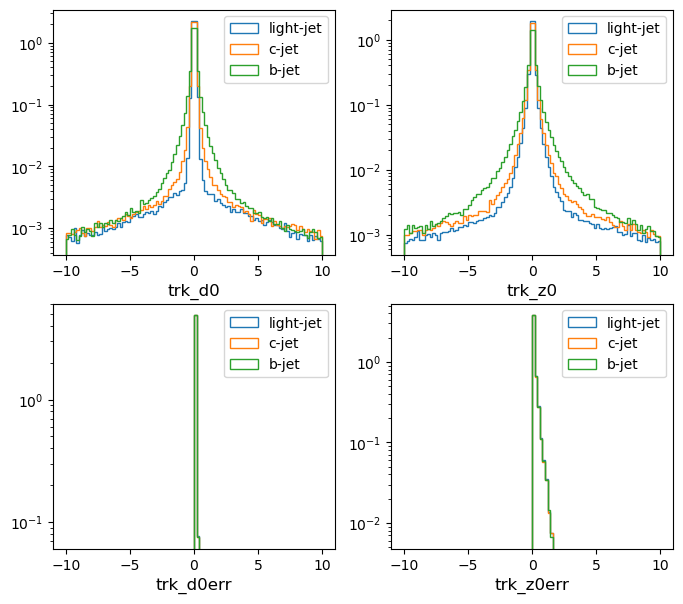

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(8, 7))

clip = (-10, 10)
kwargs = dict(bins=100, range=clip, histtype="step", density=True, log=True)

for axi, col in  zip(ax.flatten(),cols):
    for yi, label in zip([0,4,5],['light','c','b']):
        axi.hist(
            ak.flatten(arr[col][arr['jet_flav']==yi]),
            # color="C0",
            label=f"{label}-jet",
            **kwargs,
        )
    axi.set_xlabel(col, fontsize=12)
    axi.legend()

plt.show()


Additionally, below I show you the number of tracks / jet

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2732398030.py:1: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.
  plt.hist(ak.count(arr['trk_d0'], axis=1), 16, (-.5, 15.5),


(0.0, 0.15084611521075608)

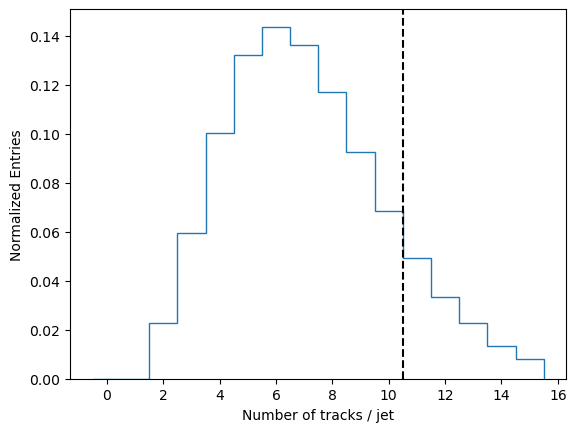

In [7]:
plt.hist(ak.count(arr['trk_d0'], axis=1), 16, (-.5, 15.5),
         histtype="step",density=True)
plt.xlabel('Number of tracks / jet')
plt.ylabel('Normalized Entries')

ylim = plt.ylim()
plt.vlines(10.5,*ylim,'k',ls='--')
plt.ylim(ylim)

Although the Deep Sets will natively process a naive number of inputs, in practice, we use regular tensors for ease with the GPU.

We'll pad jets with less than 10 tracks with fixed dimensional input vectors, and use a mask to ignore these tracks in the computation.

I provide you the code for this below:

In [8]:
mask = ~ak.is_none(ak.pad_none(arr["trk_d0"], target=10, clip=True), axis=-1)
mask


<Array [[True, True, False, ..., False, False], ...] type='181181 * 10 * bool'>

In [9]:
X = np.dstack(
    [
        ak.where(mask, ak.pad_none(arr[col], target=10, clip=True), 0.0).to_numpy()
        for col in cols
        if col[:4] == "trk_"
    ]
)

X.shape # (181k jets, 10 trks, 4 features)

(181181, 10, 4)

Now, let's put them in torch tensors... and rename the `y` labels to be 0,1,2 (for convenience with the pytorch functions)

- <span style="color:royalblue"> 0 -> **0: light-jets**</span>
- <span style="color:orange">4 -> **1 charm-jets**</span> 
- <span style="color:limegreen"> 5 -> **2: b-jets**</span>

In [13]:
import torch

X_torch = torch.FloatTensor(X)
y_torch = torch.LongTensor(arr['jet_flav'].to_numpy().astype('int'))

y_torch[y_torch == 4] = 1
y_torch[y_torch == 5] = 2

**Train / test split** (following the recommendation from lecture)

<img src="train_test.jpg"
     width=750
     style="float: left; margin-right: 10px;" />

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# train / val / test (80/20/20) split

# 20% test data
X_tr, X_test, y_tr, y_test = train_test_split(X_torch, y_torch, test_size=0.2)

# split validation set,
# 25% of remaining data goes into the validation set
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.25)


In [ ]:
# import h5py
# # Save the array to use in another nb
# f = h5py.File("../data/ftag-regular-arr.h5", "w")

# myDict = {
#     "X_tr": X_tr,
#     "y_tr": y_tr,
#     #
#     "X_val": X_val,
#     "y_val": y_val,
#     #
#     "X_test": X_test,
#     "y_test": y_test,
# }

# for key, val in myDict.items():
#     f.create_dataset(key, data=val)

# f.close()


## Step 2: Set up a Deep Sets architecture
<a name="model"></a>


In [17]:
from torch import nn
import torch.nn.functional as F
from torch import optim

`pytorch` is very modular and lets you stack layers like legos to build a custom architecture. 

Your turn! Build the Deep Sets model!!

**Set up the model skeleton** 

The model parameters are set as variables to be easy to change in the tutorial.

- `ppm_sizes_int`: A list defining the size for each of the dense layers of the per particle network Φ
- `dense_sizes_int`: A list defining the size for each of the dense layers of the per particle network F

In [18]:
# Store the dimensions of the input dataset for setting up the model
nJets, maxNumTrks, nFeatures = X_tr.shape

<img src="DIPS_architecture_tutorial.jpg"
     width=500
     style="float: left; margin-right: 10px;" />

**TO DO:** Implement the architecure above.

**Q2:** Implement the `phi` and `F` NN (in `__init__`)

**Q3:** Implement the `Sum` operation in the `forward` function

In [19]:
nClasses = len(np.unique(y_tr))
nClasses 

3

In [42]:
class DeepSet(nn.Module):
    def __init__(self):

        super().__init__()

        in_dim = 4

        # ppm_sizes_int = [50,50,32]
        # dense_sizes_int = [50,50]

        # Q2: Implement the phi and F NNs
        self.phi = nn.Sequential(
            nn.Linear(in_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100,128),
            nn.ReLU()
        )

        self.F = nn.Sequential(
            nn.Linear(128, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, nClasses)
        )
        
    def forward(self, x, debug=False):

        x = self.phi(x)

        if debug: 
            print('After Phi NN',x.shape)

        # Q3: Implement the sum operation
        # Hint: Look up torch.sum
        x = torch.sum(x,axis=1)

        if debug:
            print('After Sum',x.shape)

        x = self.F(x)

        return x


In [126]:
# Instantiate the model
dips = DeepSet()

In [127]:
X_tr.shape

torch.Size([108708, 10, 4])

In [128]:
# Evaluate the output
y_out = dips(X_tr,debug=True)

After Phi NN torch.Size([108708, 10, 128])
After Sum torch.Size([108708, 128])


In [129]:
# Little sanity check that implementation has the correct dimensionality
assert y_out.shape == (X_tr.shape[0], nClasses)

As a sanitry check, you can check the trainable layers of the model.

In [130]:
dips

DeepSet(
  (phi): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=128, bias=True)
    (5): ReLU()
  )
  (F): Sequential(
    (0): Linear(in_features=128, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=3, bias=True)
  )
)

### Loss function: Categorical cross entropy

To train the model, we mean by a model performing better or worse, which we quantify by a **loss function**. For multi-class classification, we use the categorical cross-entropy, which maximizes the node corresponding to the true label of the jet. 

For targets $y=[0,1, ..., 3]$, our model is outputting $z \in \mathbb{R}^{3}$, the logits (unnormalized probabilities) for these 3 classes.

We want to interpret the output of the model probabilistically, which we can do via the softmax:

$$\mathrm{Softmax}(z) \rightarrow p_i = \frac{\exp(z_i)}{\sum_{i=1}^K\exp(z_i)}$$

The **cross entropy** loss function is then the negative log likelihood of the training data .

$$
\mathcal{L} = - \frac{1}{N} \sum_i \log p_{y_i},
$$

where $p_{y_i}$ is the predicted probability of the true target class.

**Q4:** _Before training_ the model, what do you think the loss will be?


- A.   0
- B.   $\infty$
- C.   ln(2)
- D.   ln(3)

**Q5: Test your answer above in code** 

Tip: look at `F.cross_entropy`

In [131]:
# F.cross_entropy?

In [132]:
# Soln
with torch.no_grad():
    print(F.cross_entropy(y_out, y_tr))

tensor(1.1039)


In [133]:
# Soln:
np.log(3)

np.float64(1.0986122886681098)

**Soln:** Pretty darn close, good sanity check :)

## Setup 3. Train the model
<a name="evaluate"></a>

When training a model, we'll iterate over mini-batches of the dataset.

The function `get_batch` below takes a sample of 128 jets from the training dataset to get a single update step for the model.

In [134]:
def get_batch(batch_size):
    '''
    Draw a random sample from the training dataset
    '''
    idx = np.random.choice(len(X_tr),batch_size)
    return X_tr[idx], y_tr[idx]

We give you the code below for training a model in torch (implementing all the pieces we discussed in lecture)
- hypothesis class: NN
- Data: (x,y) pairs from `get_batch`
- Loss: cross entropy
- Optimizer: adam

In [ ]:
# Soln code
def train_model(model, lr=1e-3):
    """
    Inputs:
    - model: pytorch model
    - lr: learning rate
    """

    # print(f"training model with {count_parameters(model)} parameters")
    train_losses = []
    val_losses = []

    opt = torch.optim.Adam(model.parameters(), lr)

    for i in range(200):  # training steps

        xi, yi = get_batch(512)  # Draw batch of samples

        logits = model(xi)
        loss = F.cross_entropy(logits, yi)

        opt.zero_grad() # clear the gradients (reset the grad vector to 0)
        loss.backward() # Backprob the grad to get dL / dw 
        opt.step()  # Do the grad update step w = w - lr * (dL / dw )

        train_losses.append(float(loss))

        with torch.no_grad(): # don't include this in the grad calc

            # Q6: Calc and save the performance on the validation set
            # (e.g, append answer to val_losses)

            # Soln
            out = model(X_val)
            val_losses.append(F.cross_entropy(out, y_val))

        if i % 50 == 0:
            # print(float(loss))
            print('i=',i,'train',float(loss),'val', float(val_losses[-1]))
    return (model, train_losses, val_losses)


In [136]:
dips, train_losses, val_losses = train_model(dips)

i= 0 train 1.1029791831970215 val 1.1040005683898926
i= 50 train 1.033220887184143 val 1.0305298566818237
i= 100 train 0.9269771575927734 val 0.9135910868644714
i= 150 train 0.8795920014381409 val 0.8862583637237549


**Q6:** To test your understanding, save the performance on the validation set (modify `train_model` above)

**Q7:** Plot the training and val loss 

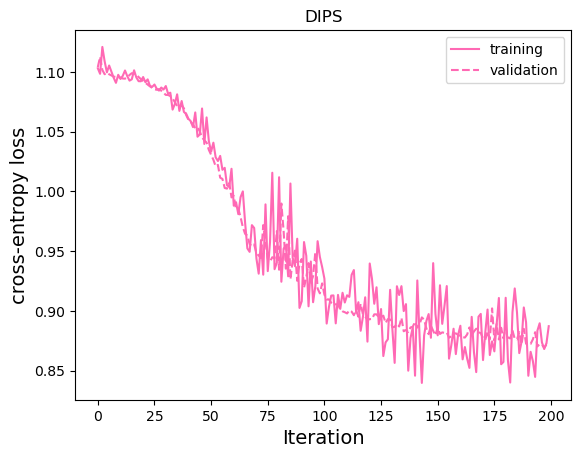

In [141]:
plt.plot(train_losses,color='hotpink',label='training')
plt.plot(val_losses, color="hotpink", label="validation", ls="--")
plt.xlabel('Iteration',fontsize=14)
plt.ylabel('cross-entropy loss',fontsize=14)
plt.legend()
plt.title('DIPS')

# plt.ylim(0,2)

plt.show()

**Intuition building:** Which is lower / higher (train or val loss)? Does this make sense?

Since only 500k jets are being used in the training rn, the model might be overfitting a bit for these hyperparameters.

**Evaluate the results with a roc curve**

For this multiclass output problem, we'll combine the three class probabilities into a single discriminant.

$$D_b = \log \frac{p_b}{f_c \cdot p_c + (1 - f_c) \cdot p_l}$$

where $f_c$ is the "charm fraction" which is a parameter we choose after training the network.

For this tutorial we will set $f_c = 0.07$.


**Q7 (warm up):** Will a $b$-jet have high or low values of $D_b$?

-> High values of $D_b$

What about $c$ and $l$-jets?

-> Low values of $D_b$

**Test your assumption** The code below does the roc curve calculation.

TO DO: Fill in the discriminant calculation (the line below starting with)

`disc = ...` 

In [142]:
def sigBkgEff(model, X_test, y_test, fc=0.07, title=''):
    """
    Given a model, make the histograms of the model outputs to get the ROC curves.

    Input:
        model: A pytorch model
        X_test: Model inputs for the test set
        y_test: Truth labels for the test set
        fc: The amount by which to weight the c-jet prob in the disc. The
            default value of 0.07 corresponds to the fraction of c-jet bkg
            in ttbar.

    Output:
        effs: A list with 3 entries for the l, c, and b effs
    """

    # Evaluate the performance with the ROC curves!
    with torch.no_grad():
        logits = model(X_test)

    # Pass the output through a Softmax to get the probabilities
    probs = F.softmax(logits)

    '''
    Q8: Set up the discriminant function
    '''
    disc = np.log( probs[:, 2] / (fc * probs[:, 1] + (1 - fc) * probs[:, 0]))
    
    # Define the min and max range for the distribution
    discMax = float(disc.max())
    discMin = float(disc.min())
    
    myRange=(discMin,discMax)
    nBins = 200

    effs = []
    for output, flavor in zip([0,1,2], ['l','c','b']):

        ix = (y_test == output)
        
        # Plot the discriminant output
        # nEntries is just a sum of the weight of each bin in the histogram.
        nEntries, edges ,_ = plt.hist(disc[ix],alpha=0.5,label=f'{flavor}-jets',
                                      bins=nBins, range=myRange, density=True, log=True)
        
        # Since high Db scores correspond to more b-like jets, compute the cummulative density function
        # from summing from high to low values, this is why we reverse the order of the bins in nEntries
        # using the "::-1" numpy indexing.
        eff = np.add.accumulate(nEntries[::-1]) / np.sum(nEntries)
        effs.append(eff)

    plt.title(title)
    plt.legend()
    plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)
    plt.ylabel('Normalized entries')
        
    return effs


<>:54: SyntaxWarning: invalid escape sequence '\l'
<>:54: SyntaxWarning: invalid escape sequence '\l'
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/3759847608.py:54: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$D = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$',fontsize=14)


<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2530566920.py:1: SyntaxWarning: invalid escape sequence '\P'
  title = 'DIPS: $\Phi$ 100-100-128, F 100-100'


/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/3759847608.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/3759847608.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  disc = np.log( probs[:, 2] / (fc * probs[:, 1] + (1 - fc) * probs[:, 0]))


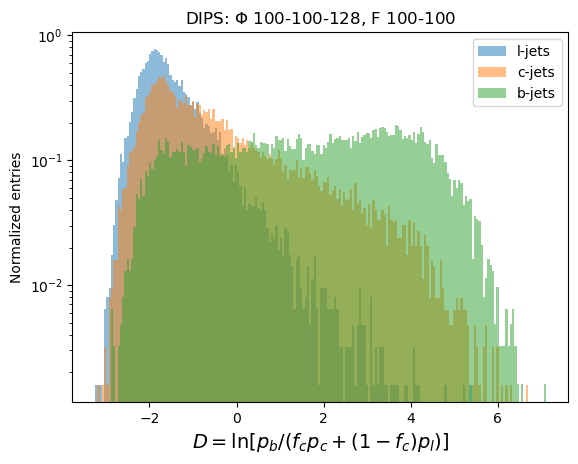

In [143]:
title = 'DIPS: $\Phi$ 100-100-128, F 100-100' 

leff, ceff, beff = sigBkgEff(dips, X_test, y_test, title=title)

**Q9:** Plot the ROC curve with
- b-tagging efficiency on the x axis
- light / charm rejection on the y-axis

(Recall: rejection = 1/ mis-tag efficiency)

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2013642462.py:7: RuntimeWarning: divide by zero encountered in divide
  plt.plot(beff, 1 / leff, color='hotpink', label='dips: l-rej')
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2013642462.py:10: RuntimeWarning: divide by zero encountered in divide
  plt.plot(beff, 1 / ceff, color='hotpink', linestyle='--', label='dips: c-rej')
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2013642462.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,int(100))


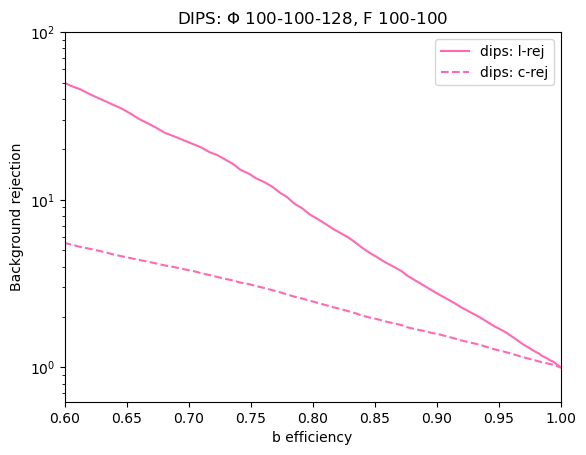

In [144]:
'''
Q9: Soln
'''

# l-rej
plt.figure()
plt.plot(beff, 1 / leff, color='hotpink', label='dips: l-rej')

# c-rej
plt.plot(beff, 1 / ceff, color='hotpink', linestyle='--', label='dips: c-rej')
plt.xlabel('b efficiency')
plt.ylabel('Background rejection')

plt.legend()
plt.title(title)
plt.yscale("log")
plt.xlim(0.6,1)
plt.ylim(0,int(100))

plt.show()

**Q10:** Which is harder to reject, light or charm jets?

Does this make sense given the input distributions you looked at in **Q1**?

**Soln:** c-jets are harder to reject (lower rejection).

This makes sense b/c in the plot we made in Q1, c-jets also have larger impact parameters (d0 and z0), because they are also decaying by the weak force and have a correspondingly longer lifetime (albeit, not as long as b-jets).

## Step 4: (Bonus) Layer normalization
<a name="dataset"></a>

**Goal:** Implement the layer normalization in the Deep Set model

Tips:
- Look up `nn.LayerNorm`
- Put this layer normalization right before the nonlinearity

In [145]:
class DeepSet_ln(nn.Module):
    def __init__(self):
        super().__init__()

        in_dim = 4

        self.phi = nn.Sequential(
            nn.Linear(in_dim, 50),
            nn.LayerNorm(50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.LayerNorm(50),
            nn.ReLU(),
            nn.Linear(50, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
        )

        self.F = nn.Sequential(
            nn.Linear(32, 50),
            nn.LayerNorm(50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.LayerNorm(50),
            nn.ReLU(),
            nn.Linear(50, nClasses),
        )

    def forward(self, x, debug=False):
        
        x = self.phi(x)
        x = torch.sum(x, axis=1)
        x = self.F(x)

        return x


In [146]:
dips_ln = DeepSet_ln()

In [147]:
dips_ln, tr_ln_loss, val_ln_loss = train_model(dips_ln)

i= 0 train 1.2011520862579346 val 1.1496336460113525
i= 50 train 0.9373900890350342 val 0.9486947059631348
i= 100 train 0.8577094078063965 val 0.8843874335289001
i= 150 train 0.9053397178649902 val 0.882794976234436


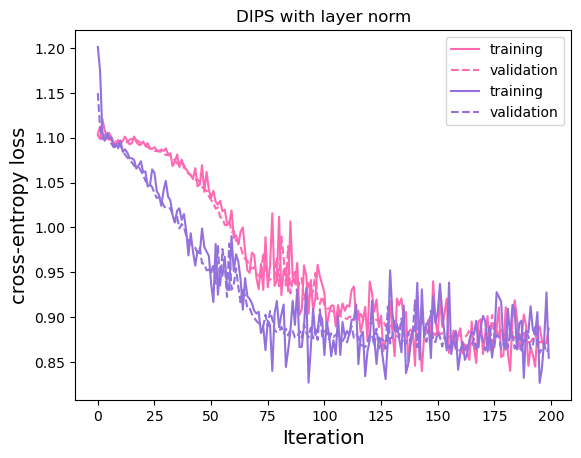

In [150]:
plt.plot(train_losses, color="hotpink", label="training")
plt.plot(val_losses, color="hotpink", label="validation", ls="--")

plt.plot(tr_ln_loss, color="mediumpurple", label="training")
plt.plot(val_ln_loss, color="mediumpurple", label="validation", ls="--")
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("cross-entropy loss", fontsize=14)
plt.legend()
plt.title("DIPS with layer norm")

plt.show()


Great! As predicted in lecture, Layer norm is training more quickly.

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/3759847608.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/3759847608.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  disc = np.log( probs[:, 2] / (fc * probs[:, 1] + (1 - fc) * probs[:, 0]))


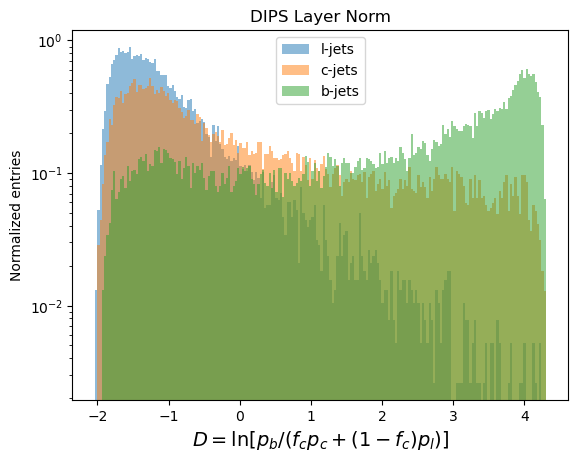

In [153]:
leff_ln, ceff_ln, beff_ln = sigBkgEff(dips_ln, X_test, y_test, title="DIPS Layer Norm")

/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2980407820.py:10: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2980407820.py:12: RuntimeWarning: divide by zero encountered in divide
  ax1.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
/var/folders/5j/ynfw2g6n2cgdwgp6xdh3byn00000gp/T/ipykernel_93725/2980407820.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0,int(100))


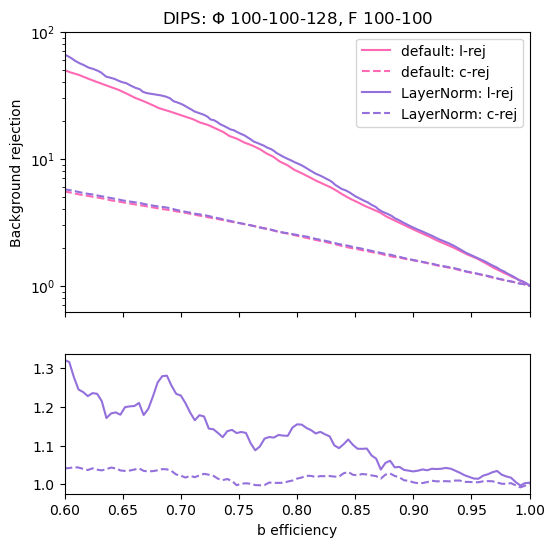

In [154]:
from scipy.interpolate import pchip

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,6),sharex=True,
                              gridspec_kw={'height_ratios':[2,1]})

for bi,li,ci,c, l in zip([beff,beff_ln],[leff,leff_ln],[ceff,ceff_ln],
                         ['hotpink','mediumpurple'],['default','LayerNorm']):

    # l-rej
    ax1.plot(bi, 1 / li, color=c, label=f'{l}: l-rej')
    # c-rej
    ax1.plot(bi, 1 / ci, color=c, linestyle='--', label=f'{l}: c-rej')
    
    
# Also the ratio panel
xx = np.linspace(0.6,1,101)

dx = np.concatenate((np.ones(1),np.diff(beff)))
dx_ln = np.concatenate((np.ones(1),np.diff(beff_ln)))

# l-rej
for bkg,bkg_ln, ls in zip([leff,ceff],[leff_ln,ceff_ln],['-','--']):
    
    m_num = (bkg_ln!=0) & (dx_ln>0)
    m_den = (bkg!=0) & (dx>0)
    
    f_num = pchip(beff_ln[m_num], 1/bkg_ln[m_num]) 
    f_den = pchip(beff[m_den],    1/bkg[m_den]) 

    ax2.plot(xx, f_num(xx) / f_den(xx), ls=ls, color=c)
    
ax2.set_xlabel('b efficiency')
ax1.set_ylabel('Background rejection')
ax1.set_ylabel('Background rejection')

ax1.legend()
ax1.set_title(title)
ax1.set_yscale("log")
ax1.set_xlim(0.6,1)
ax1.set_ylim(0,int(100))

plt.show()

And... it is infact helping the performance!!

**Super bonus Q:** Can you plot the activations of the networks with and without layer normalization?

(Is layer norm having the desired affect of encouraging activations to zero mean and unit variance?)

https://github.com/usatlas-ml-training/Deep-Sets

And... that's it for today!!


Just as a reminder what we learned in this tutorial:

1. Visualizing the dataset
2. Building a Deep Sets model for a multi-class classification problem
    - Sanity checking... model at initialization
3. Training model and evaluating performance
4. First foyay into (more on this in the next section!)

But the biggest take away is... hopefully you're convinced that Deep Sets is a fast and easy model to get running - and inspired to test it out on some of your LHC research problems :) 